In [52]:
from scipy import stats
import numpy as np                  # import a package with specified name
from sklearn import linear_model    # import whole module
from os import mkdir, rmdir, path   # import a function
from inspect import getsourcelines  # get function source code
import string
import time
import pandas as pd
import matplotlib.pyplot as plt     # for plots
import seaborn as sns               # for plots
import datetime

sns.set_palette("colorblind")
color_blind_list = sns.color_palette("colorblind", 8)
plt.style.use('bmh')

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exercice 1 (Exploration des données, recherche de leur loi):

##### 1. Former un vecteur des coût des accidents (strictement) avant l’accident de Three Mile Island, en million dollars 2013 et supprimer toutes les observations (avec données) manquantes. Vous devez obtenir n = 55 observations x1,...,xn

In [54]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NuclearPowerAccidents2016.csv')
df.head()

,Date,Location,Cost (millions 2013US$),INES,Smyth Magnitude,Region,Description,Fatalities
0,4/26/1986,"Kiev, Ukraine",259336.0,7.0,8.0,EE,Mishandled reactor safety test at Chernobyl nu...,4056
1,3/11/2011,"Fukushima Prefecture, Japan",166089.0,7.0,7.5,A,An earthquake and tsunami caused emergency bac...,573
2,12/8/1995,"Tsuruga, Japan",15500.0,NaN,NaN,A,Japan's only fast breeder reactor Monju suffer...,0
3,3/28/1979,"Middletown, Pennsylvania, United States",10910.0,5.0,7.9,NaN,Equipment failure and operator error contribut...,0
4,9/11/1957,"Rocky Flats, USA",8189.0,5.0,5.2,NaN,Fire starts and destroys plutonium processing ...,0


In [55]:
df['Date'] = pd.to_datetime(df['Date'])
mask = df['Date'] < '28/03/1979'
df_before_accident = df[mask]
df_cost = df_before_accident['Cost (millions 2013US$)']
df_cost = df_cost.dropna(axis=0)
df_cost.head()

4    8189.0
5    4400.0
6    3500.0
7    2900.0
8    2500.0
Name: Cost (millions 2013US$), dtype: float64

In [56]:
df_cost.size

55

### 2. Construction d’un QQ-plot normal.

Exprimons la fonction de répartition de $X ~ N(μ, σ²)$  à l'aide de la fonction de répartition de $Y ~ N(0, 1)$. \\
On a: $$F(X ≤ x) = \frac{1}{\sqrt{2πσ²}} \int_{-∞}^x exp(\frac{(t-μ)²}{2σ²})  dt $$	\\
On procède au changement de variable $$ u = \frac{t-μ}{σ} $$ et on obtient: 
$$ F(X ≤ x) = \frac{σ}{\sqrt{2πσ²}} \int_{-∞}^{\frac{x-μ}{σ}} exp(\frac{u²}{2})  du $$	\\
D'où: $$ F(X ≤ x) = F(Y ≤ \frac{x-μ}{σ}) $$ \\
Par conséquent, $F(X ≤ x) = p$ équivaut à $\frac{x-μ}{σ} = F^{-1}(p; 0, 1)$, et donc $x = μ + σ F^{-1}(p; 0, 1)$ \\
Ainsi, on a montré que: $$F^{-1}(p; μ, σ²) = μ + σ F^{-1}(p; 0, 1) $$




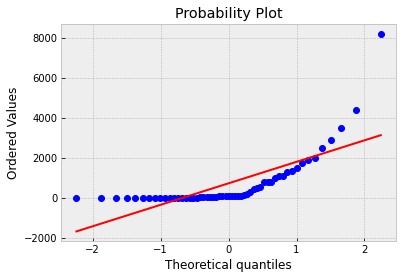

In [57]:
from scipy import stats
_, _ = stats.probplot(df_cost, dist='norm', plot = plt)
plt.show()

La modélisation normale ne semble pas très adaptée sur notre dataframe.

## 3. Construction d’un QQ-plot exponentiel.

La fonction de répartition d'une loi exponentielle de paramètre λ est: 
$$ F(X ≤ x) = 1 - exp(-λx) $$\
Ainsi $$F(X ≤ x) = p$$ équivaut à $$x = - \frac{ln(1-p)}{λ}$$. \\
D'où: $$ F^{-1}(p; λ) = - \frac{ln(1-p)}{λ}$$ et $$F^{-1}(p; 1) = - ln(1-p) $$\
On retrouve bien: $$F^{-1}(p; λ) = \frac{F^{-1}(p; 1)}{λ}$$ 

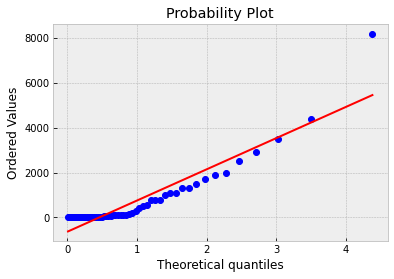

In [58]:
_, _ = stats.probplot(df_cost, dist='expon', plot = plt)
plt.show()

## 4. Loi la plus plausible

Le diagramme QQ permetd'évaluer la pertinence de l'ajustement d'une distribution donnée à un modèle théorique. \\
Plus les points de notre dataset sont proches de la droite théorique rouge, plus le modèle théorique est bon. \\
Clairement, la courbe obtenue avec la loi exponentielle permet au point d'épouser bien mieux cette courbe par rapport à la droite obtenue avec la loi normale. \\
On pourrait par exemple calculer l'erreur quadratique moyenne pour s'appercevoir que celle obtenue avec la loi normale est nettement supérieur à celle obtenue avec la loi exponentielle.

# Exercice 2 : Estimation ponctuelle des paramètres d’une loi exponentielle

## 1. Indicateur de vraissemblance d'une loi exponentielle.

L'indépendance des $X_{i}$ implique que la vraissemblance des observations est donnée par le produit des densités: $$p(X_{1} = x_{1}, ..., X_{n} = x_{n}; λ) = λ^{n} exp(-λ \sum_{i=1}^n x_{i})$$ \\
La log-vraissemblance est: $$ln(p(X, λ)) = n ln(λ) - λ \sum_{i=1}^n x_{i}$$ \\
En annulant la dérivée par rapport à t, on obtient l'estimateur de vraissemblance: $$\hat{λ_{n}} =  \frac{n}{\sum_{i=1}^n x_{i}} = \frac{1}{\bar{X_{n}}}$$ \\

## 2. Histogramme de données et densité de probabilité de la loi exponentielle

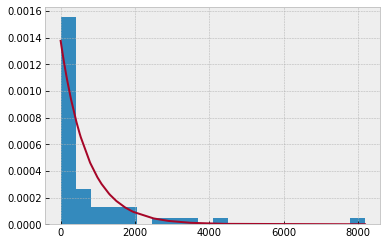

In [59]:
theta = df_cost.size / np.sum(df_cost) 
exp_density = theta * np.exp(-theta * df_cost)
_ = plt.hist(df_cost, bins=20, density=True)
_ = plt.plot(df_cost, exp_density)
plt.show()

## 3. Estimateur efficace pour $g_{1}(λ)$

Pour que $T_{1}(X)$ soit un estimateur efficace pour $g_{1}(λ)$, il faut qu'il soit non biaisé et qu'il atteint la borne de Cramér-Rao. \\
Par linéarité de l'espérence, $T_{1}(X)$ est de biais nul, il suffit donc qu'il atteint la borne de Cramér-Rao: $$Var_{λ}(T_{1}(X)) ≥ \frac{g'(λ)²}{I(λ)}$$ \\
D'une part on a $$g'(λ) = - \frac{1}{λ²}$$ \\
Et : $$I(λ) = - E_{λ} (\frac{\partial^2 ln(p)}{\partial x^2}(X; λ))$$ \\
Or $$p(x; λ) = - λ^{n} exp(- λ \sum_{i=1}^n x_{i}) $$\
D'où: $$ln(p) = n ln(λ) - λ \sum_{i=1}^n x_{i}$$ \\
Puis: $$\frac{\partial^2 ln(p)}{\partial x^2}(X; λ) = - \frac{n}{λ²}$$ \\
On en déduit $$I(λ) = \frac{n}{λ²}$$ Puis $$\frac{g'(λ)}{I(λ)} = \frac{1}{n λ²}$$ \\
D'autre par, par indépendance des $X_{i}$, $$Var_{λ}(T_{1}(X)) = \frac{1}{n²} \sum_{i=1}^n Var(X_{i})$$ \\
Donc $$Var_{λ}(T_{1}(X)) = \frac{1}{n λ²}$$ \\
On a bien égalité, et par conséquent $T_{1}(X)$ est un estimateur efficace pour $g_{1}(λ)$

## 4. Calcul de $g_{1}$

In [60]:
g1 = np.sum(df_cost) / df_cost.size
g1

726.3363636363637

## 5. Etude de $\tilde{T}_{1, η}(X) = η T_{1}(X)$

D'une part, on a $$R(λ, T_{1}) = b(λ, \hat{g})² + Var(\hat{g}(X)) = Var(\hat{g}(X)) = \frac{1}{n λ²}$$ car $T_{1}$ est de biais nul. \\
D'autre part, $\tilde{T}_{1, η}(X)$ est biaisé de biais = $\frac{η - 1}{λ}$ (par linéarité de l'espérence) \\
Puis, par propriété quadratique de la variance: $$Var(\tilde{T}_{1, η}(X)) = \frac{η²}{n λ²}$$ \\
Donc l'erreur quadratique moyenne vaut: $$R(λ, \tilde{T}_{1, η}) = \frac{(η - 1)²}{λ²} + \frac{η²}{n λ²}$$ \\
Une résolution de $R(λ, \tilde{T}_{1, η}) < R(λ, T_{1})$ sur $η$ nous ammène à $$\frac{n-1}{n+1} < η < 1$$ \\
Pour ces valeurs de $η$, l'erreur quadratique moyenne est plus faible pour $\tilde{T}_{1, η}$ que pour $T_{1}$: $\tilde{T}_{1, η}$ est une meilleur estimateur que $T_{1}$ dans le sens de l'erreur quadratique moyenne. \\
Cependant, cela n'est pas en contradiction avec la question précédente, car $\tilde{T}_{1, η}$ n'est pas sans biais.

## 6. Estimateur sans biais de la médiane

La médiane est atteinte pour $x$ tel que: $$F(X ≤ x) = 0.5$$ \\
C'est-à-dire tel que: $$1 - exp(-λx) = 0.5$$ \\
Soit pour $$x = \frac{ln(2)}{λ}$$
Par linéarité de l'espérence, on cherche donc $η$ tel que $$E(\tilde{T}_{1, η}(X)) = \frac{ln(2)}{λ}$$ \\
Autrement dit, on cherche $η$ tel que $$\frac{η}{λ} = \frac{ln(2)}{λ}$$ \\
Soit: $$η = ln(2)$$

##### Calcul de l'estimateur pour cette valeur de $η$ et médiane empirique

In [61]:
eta = np.log(2)
g_eta = eta * g1
median = np.median(df_cost)

print(f'g_eta = {g_eta}')
print(f'Médiane empirique = {median}')

g_eta = 503.4580025927086
Médiane empirique = 89.9


La forte différence peut s'expliquer par notre dataset qui est assez petit.

## 7. Comparaison des risques quadratiques

D'après le point 5., $R(λ, \tilde{T}_{1, η}) < R(λ, T_{1})$ équivaut à $\frac{n-1}{n+1} < η < 1$. \\
Or ici $η = ln(2) < 1$. \\
On a donc $R(λ, \tilde{T}_{1, η}) < R(λ, T_{1})$ pour n tel que $\frac{n-1}{n+1} < ln(2)$, c'est à dire pour $n < \frac{1 + ln(2)}{1 - ln(2)}$, d'où $n < 6$. Vu la taille du dataframe (55) on s'attend à avoir $R(λ, \tilde{T}_{1, η}) > R(λ, T_{1})$. \\
Je rappelle les formules établies au point 5. : $$R(λ, \tilde{T}_{1, η}) = \frac{(η - 1)²}{λ²} + \frac{η²}{n λ²}$$ et $$R(λ, T_{1}) = \frac{1}{n λ²}$$


In [62]:
n = df_cost.size
R_tild = ( (eta - 1)  / theta )**2 + eta**2 / (n*theta**2)
R_ = 1 / (n*theta**2 )
print(f'R_T_tild = {R_tild}')
print(f'R_T1 = {R_}')

R_T_tild = 54283.3085555902
R_T1 = 9592.082057099926


On a bien le résultat attendu.

# Exercice 3 : Test sur le paramètre d’une loi

## 1. Hypothèse nulle est hypothèse alternative

La probabilité d'une loi exponentielle étant $1 / λ$ on a que:


*   L'hypothèse nulle $H_{0}$: $λ > \frac{1}{1000}$
*   L'hypothèse alternative $H_{1}$: $λ ≤ \frac{1}{1000}$




## 2. Test le plus puissant pour le niveau $α$

Prenons $λ_{0} > λ_{1}$.
Le rapport de vraissemblance $Z$ est: $$Z(x) = \frac{p_{λ_{0}}(x)}{p_{λ_{1}}(x)} = (\frac{λ_{0}}{λ_{1}})^{n} exp((λ_{1} - λ_{0}) \sum_{i=1}^n x_{i}) = (\frac{λ_{1}}{λ_{0}})^{n} exp((λ_{0} - λ_{1}) T(X)) = f(T(X))$$
Avec $T(X) = \sum_{i=1}^n x_{i}$. \\
Puisque $λ_{0} > λ_{1}$, f est strictement décroissante, elle satisfait l'hypothèse MON.
D'après le théorème de Neyman-Pearson, on rejette $H_{0}$ si $T(X) < c$, où $c$ est tel que $P(T(X) < c) = α$ où l'on suppose $H_{0}$, c'est-à-dire $λ_{0} > \frac{1}{1000}$. \
Or $T(X)$ suit une loi $Γ(n, λ_{0})$ car c'est une somme de lois exponentielles iid. \\
Donc on peut obtenir $$c = F^{-1}(α; n, λ_{0})$$

## 3. Test pour $α = 0.05$

In [63]:
alpha = 0.05
lambda0 = 1/999 # On suppose H0, c'est-à-dire que lambda0 > 1/1000
n = df_cost.size
c = stats.gamma.ppf(q=alpha, a=n, scale=1/lambda0)
print(f'On rejette H0 : {np.sum(df_cost) < c}')

On rejette H0 : True


Ainsi, on rejette $H_{0}$: le coût moyen d'accident est supérieur à 1 milliard de dollars.

La p-valeur est la probabilité que, sous $H_{0}$, la statistique de
test prenne une valeur au moins aussi extrême que celle qui a
été observée, c'est-à-dire: $$ p = P(\sum_{i=1}^n X_i < \sum_{i=1}^n \bar{X_{i}} ) $$
D'où $$ p = F(\sum_{i=1}^n \bar{X_{i}}; n, λ_{0}) $$

In [64]:
p_valeur = stats.gamma.cdf(x=np.sum(df_cost), a=n, scale=1/lambda0)
print(f'On rejette H0: {p_valeur < alpha}')
print(f'p_valeur = {p_valeur}')

On rejette H0: True
p_valeur = 0.013953688417941978


La p-valeur est inférieur à $α$, nous pouvons alors rejeter $H_{0}$: le coût moyen d'accident est supérieur à 1 milliard de dollars.

## 4. Densité de probabilité T1

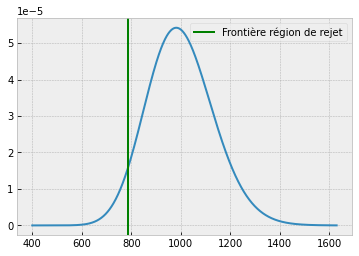

In [65]:
lambda0 = 1/1000
start = 400
end = 1630
density_function = stats.gamma.pdf(x=np.linspace(start*n, n*end, end-start), a=n, scale=1/lambda0)
plt.plot(np.linspace(start, end, end-start), density_function)
plt.axvline(x=c/n, color = 'g', label = 'Frontière région de rejet')
plt.legend()
plt.show()

La région de rejet au seuil $α = 0.05$ se situe à gauche de la frontière.

## 5. Fonction puissance de test

La puissance d'un test est la probabilité qu'en supposant $H_{1}$ ($λ_{1} < \frac{1}{1000}$) on ait $H_{1}$ \\
Autrement dit la fonction puissance de test vaut: 
$$puissance(λ_{1}) = P(\frac{1}{n}\sum_{i=1}^nX_{i} > 1000)$$
D'où:$$puissance(λ_{1}) = 1 - P(\sum_{i=1}^nX_{i} < 1000n)$$

In [66]:
def fonction_puissance_test(n):
  lambda1 = np.linspace(1/10000000, 1/1000, 100)
  p = 1 - stats.gamma.cdf(x=1000*n, a=n, scale=1/lambda1)
  plt.plot(lambda1, p, label=f'n={n}')

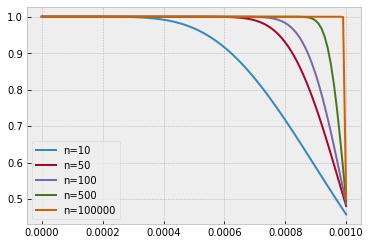

In [67]:
fonction_puissance_test(10)
fonction_puissance_test(50)
fonction_puissance_test(100)
fonction_puissance_test(500)
fonction_puissance_test(100000)
plt.legend()
plt.show()

Lorsque $λ$ est petit, alors on se situe loin de la région $Θ_{0}$ est donc la probabilité d'avoir $H_{1}$ est quasiment égale à 1. \\
Lorsque $λ$ grandit, on se rapproche de la zone où $λ$ appartient à $Θ_{0}$, et donc la probabilité diminue et se rapproche de 0.5. \\
D'après la loi des grands nombres, plus la taille de l'échantillon augmente, plus la probabilité que l'espérance égale à l'espérance théorique est proche de 1. Ainsi, ici l'espérance théorique étant inférieure à 1000n, on observe bien que plus la taille de l'échantillon augmente, plus la probabilité est quasiment égale à 1 sur tout le domaine $Θ_{1}$. \\
Autrement dit, plus la taille de l'échantillon est élevé, plus la puissance du test l'est aussi, ce qui parait logique.

## 6. Approximation de la loi $T_{1}$ et nouveau test

Les $X_{i}$ étant iid, on peut leur appliquer le théorème central limite. \\On rappelle qu'on a pour des lois exponentielles: $$E(X) = \frac{1}{λ}$$ et $$V(X) = \frac{1}{λ²}$$
Donc: $$\lim\limits_{n \to ∞}P(\frac{T_{1}(X)-1/λ}{\sqrt{n}/λ} < c) = F(c; 0, 1)$$
Où $F$ est la fonction de répartition d'une loi normale de paramètres $(0, 1)$.
Donc $T_{1}$ suit une loi normale de paramètres $(\frac{1}{λ}, \frac{1}{nλ^2})$.

Créons maintenant un nouveau test. \\
Supposons $H_{0}$ à la frontière pour que le risque de première espèce soit maximal: $λ_{0} = 1/1000$\
Regardons pour quel $c$ nous avons: $$P(T_{1}(X) < c) = α$$
Le test est donc de rejeter $H_{0}$ si $$T_{1}(X) < c$$

In [68]:
alpha = 0.05
lambda0 = 1/1000 # On suppose H0 à la frontière
n = df_cost.size
c = stats.norm.ppf(q=alpha, loc=1/lambda0, scale=np.sqrt(1/(n*(lambda0**2))))
print(f'On rejette H0 : {(1/n)*np.sum(df_cost) < c}')
print(f'c={c}')

On rejette H0 : True
c=778.2079821874304


Ainsi, on rejette $H_{0}$: le coût moyen d'accident est supérieur à 1 milliard de dollars.
Nous pouvons chercher la p-valeur de la même manière que pour la question 3:
$$p = P(T_{1}(X) < \bar{X_{n}})$$

In [69]:
p_valeur = stats.norm.cdf(x=(1/n)*np.sum(df_cost), loc=1/lambda0, scale=np.sqrt(1/(n*(lambda0**2))))
print(f'On rejette H0: {p_valeur < alpha}')
print(f'p_valeur = {p_valeur}')

On rejette H0: True
p_valeur = 0.021201463906399102


La p-valeur est inférieur à $α$, nous pouvons alors rejeter $H_{0}$: le coût moyen d'accident est supérieur à 1 milliard de dollars.

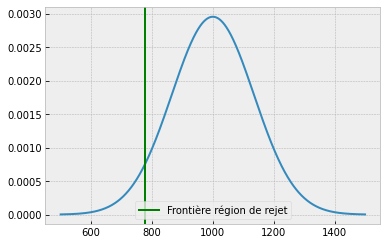

In [70]:
start = 500
end = 1500
density_function = stats.norm.pdf(x=np.linspace(start, end, end-start), loc=1/lambda0, scale=np.sqrt(1/(n*(lambda0**2))))
plt.plot(np.linspace(start, end, end-start), density_function)
plt.axvline(x=c, color = 'g', label = 'Frontière région de rejet')
plt.legend()
plt.show()

La région de rejet au seuil $α = 0.05$ se situe à gauche de la frontière.

On pourrait également tracé les fonctions puissances de test comme précédemment.
$$puissance(λ_{1}) = 1 - P(T_{1}(X) < 1000n)$$

In [71]:
def fonction_puissance_test(n):
  lambda1 = np.linspace(1/10000000, 1/1000, 100)
  p = 1 - stats.norm.cdf(x=1000, loc=1/lambda1, scale=np.sqrt(1/(n*(lambda1**2))))
  plt.plot(lambda1, p, label=f'n={n}')

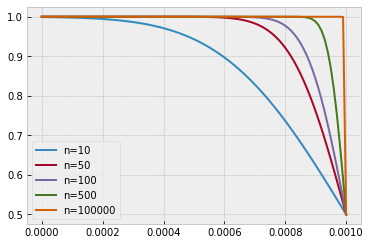

In [72]:
fonction_puissance_test(10)
fonction_puissance_test(50)
fonction_puissance_test(100)
fonction_puissance_test(500)
fonction_puissance_test(100000)
plt.legend()
plt.show()

On pourrait faire les mêmes commentaires que pour la loi gamma.